In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import rasterio
from rasterio.plot import plotting_extent, show, show_hist, reshape_as_image
from rasterio.mask import mask
import os

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [6]:
def convert_to_reflectance(band):
    """
    Convert a band from digitized to reflectance. 
    Works for bands 1-7 only.
    """
    mult_parameter = 2.75e-05
    add_parameter = -0.2
    return band * mult_parameter + add_parameter

Steps:
- read in data
- crop data to size of area in question
- group cropped bands data together and store as new file 

Landsat 5...
- Band 1 Visible Blue (0.45 - 0.52 µm) 30 m
- Band 2 Visible Green (0.52 - 0.60 µm) 30 m
- Band 3 Visible Red (0.63 - 0.69 µm) 30 m
- Band 4 Near-Infrared (0.76 - 0.90 µm) 30 m
- Band 5 Near-Infrared (1.55 - 1.75 µm) 30 m
- Band 6 Thermal (10.40 - 12.50 µm) 120 m
- Band 7 Mid-Infrared (2.08 - 2.35 µm) 30 m

NDVI = NIR(4) - red(3) / NIR(4) + red(3)

NDWI = green(2) - NIR(4) / green(2) + NIR(4)

In [7]:
# read in data

def preprocess_data(folder_path : str, area_of_interest : geopandas.GeoDataFrame, create_new = True, new_file_name = "", bands = [1, 2, 3, 4]):
    
    file_destination = "data/combined_rasters"
    new_file_path = os.path.join(file_destination, new_file_name)

    if create_new:

        band_data_combined = []
        for band in bands:
            band_substring = f"_B{band}"
            # find band file in folder
            band_file = [f for f in os.listdir(folder_path) if band_substring in f][0]
            band_path = os.path.join(folder_path, band_file)
            # read in band file
            with rasterio.open(band_path) as band_data:

                area_of_interest = area_of_interest.to_crs(band_data.crs)
                
                cropped_band_data, transform = mask(band_data, area_of_interest.geometry, crop=True)
                cropped_reflectance_band_data = convert_to_reflectance(cropped_band_data)
                band_data_combined.append(cropped_reflectance_band_data)

                meta = band_data.meta.copy()
                meta.update(
                    {                    
                        "transform": transform,
                        "height":cropped_reflectance_band_data.shape[1],
                        "width":cropped_reflectance_band_data.shape[2],
                        "count":len(bands),
                        "dtype": cropped_reflectance_band_data.dtype
                    }
                )

            print(f"Band {band} done")

        combined_bands_final = np.vstack(band_data_combined)

        with rasterio.open(new_file_path, "w", **meta) as dest:
            dest.write(combined_bands_final)

    else:
        
        combined_bands_final = rasterio.open(new_file_path)

    return combined_bands_final    

In [8]:
cropped_data_area = geopandas.read_file("data/map_jaffna_aoi.geojson")
#cropped_data_area.crs = "EPSG:32644"
#cropped_data_area

pre_tsu_raster = preprocess_data(folder_path = "data/pre_tsu", area_of_interest = cropped_data_area, create_new = True, new_file_name = "pre_tsunami_processed.tif", bands = [1, 2, 3, 4])
post_tsu_raster = preprocess_data(folder_path = "data/eight_days_post_tsu", area_of_interest = cropped_data_area, create_new = True, new_file_name = "directly_post_tsunami_processed.tif", bands = [1, 2, 3, 4])
one_month_post_tsu_raster = preprocess_data(folder_path = "data/one_month_post_tsu", area_of_interest = cropped_data_area, create_new = True, new_file_name = "one_month_post_tsunami_processed.tif", bands = [1, 2, 3, 4])

Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 1 done
Band 2 done
Band 3 done
Band 4 done


In [9]:
pre_tsu_raster = preprocess_data(folder_path = "data/pre_tsu", area_of_interest = cropped_data_area, create_new = False, new_file_name = "pre_tsunami_processed.tif", bands = [1, 2, 3, 4])
post_tsu_raster = preprocess_data(folder_path = "data/eight_days_post_tsu", area_of_interest = cropped_data_area, create_new = False, new_file_name = "directly_post_tsunami_processed.tif", bands = [1, 2, 3, 4])
one_month_post_tsu_raster = preprocess_data(folder_path = "data/one_month_post_tsu", area_of_interest = cropped_data_area, create_new = False, new_file_name = "one_month_post_tsunami_processed.tif", bands = [1, 2, 3, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6319246036075218..5.062387494787583].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2571108936048931..10.070793938099648].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2903589571401137..10.337146253084272].


Text(0.5, 1.0, 'One Month Post-Tsunami')

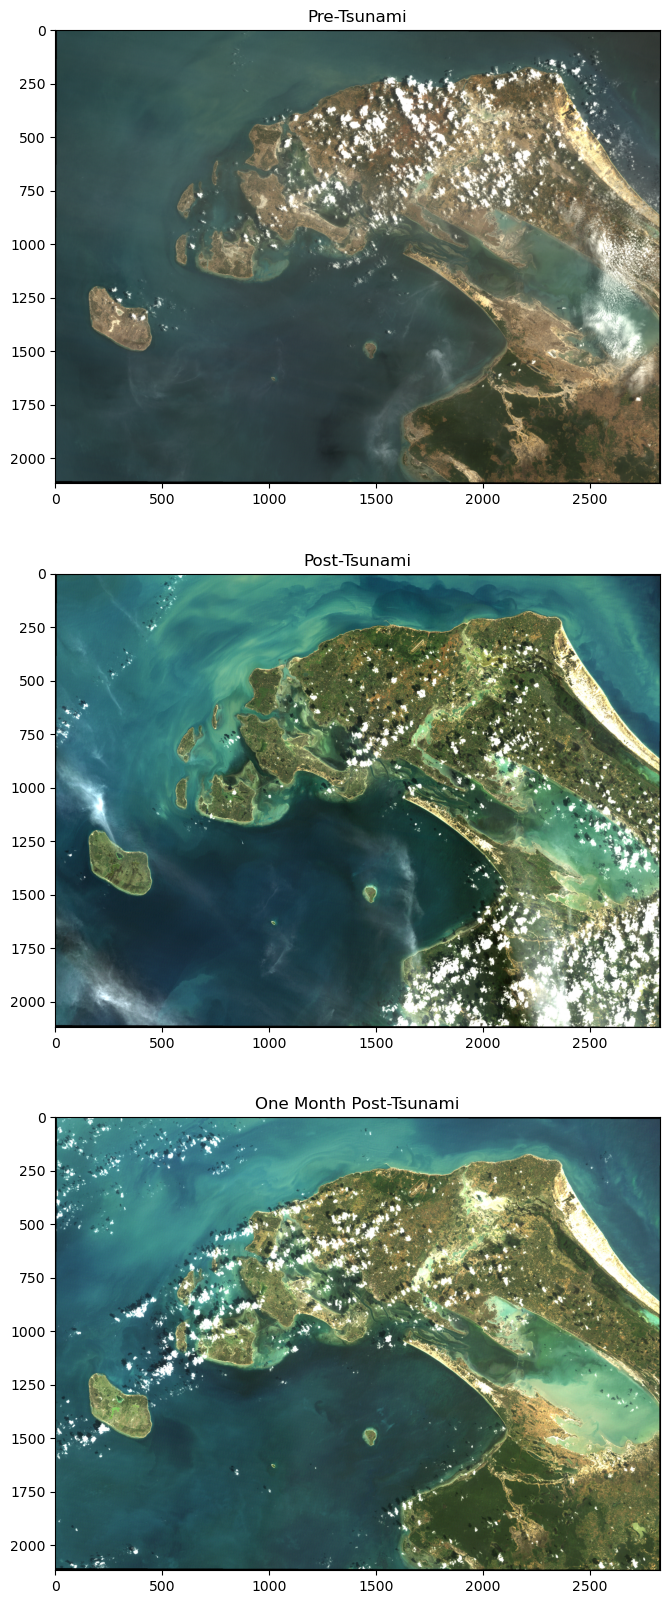

In [10]:
# compare red green blue of each image
pre_tsu_factor=3*np.mean(pre_tsu_raster.read(3))
pre_tsu_rgb = np.dstack((pre_tsu_raster.read(3),pre_tsu_raster.read(2),pre_tsu_raster.read(1)))/pre_tsu_factor
post_tsu_factor=3*np.mean(post_tsu_raster.read(3))
post_tsu_rgb = np.dstack((post_tsu_raster.read(3),post_tsu_raster.read(2),post_tsu_raster.read(1)))/post_tsu_factor
one_month_post_tsu_factor=3*np.mean(one_month_post_tsu_raster.read(3))
one_month_post_tsu_rgb = np.dstack((one_month_post_tsu_raster.read(3),one_month_post_tsu_raster.read(2),one_month_post_tsu_raster.read(1)))/one_month_post_tsu_factor
fig, axs = plt.subplots(3, 1, figsize=(10, 20))
axs[0].imshow(pre_tsu_rgb)
axs[0].set_title("Pre-Tsunami")
axs[1].imshow(post_tsu_rgb)
axs[1].set_title("Post-Tsunami")
axs[2].imshow(one_month_post_tsu_rgb)
axs[2].set_title("One Month Post-Tsunami")

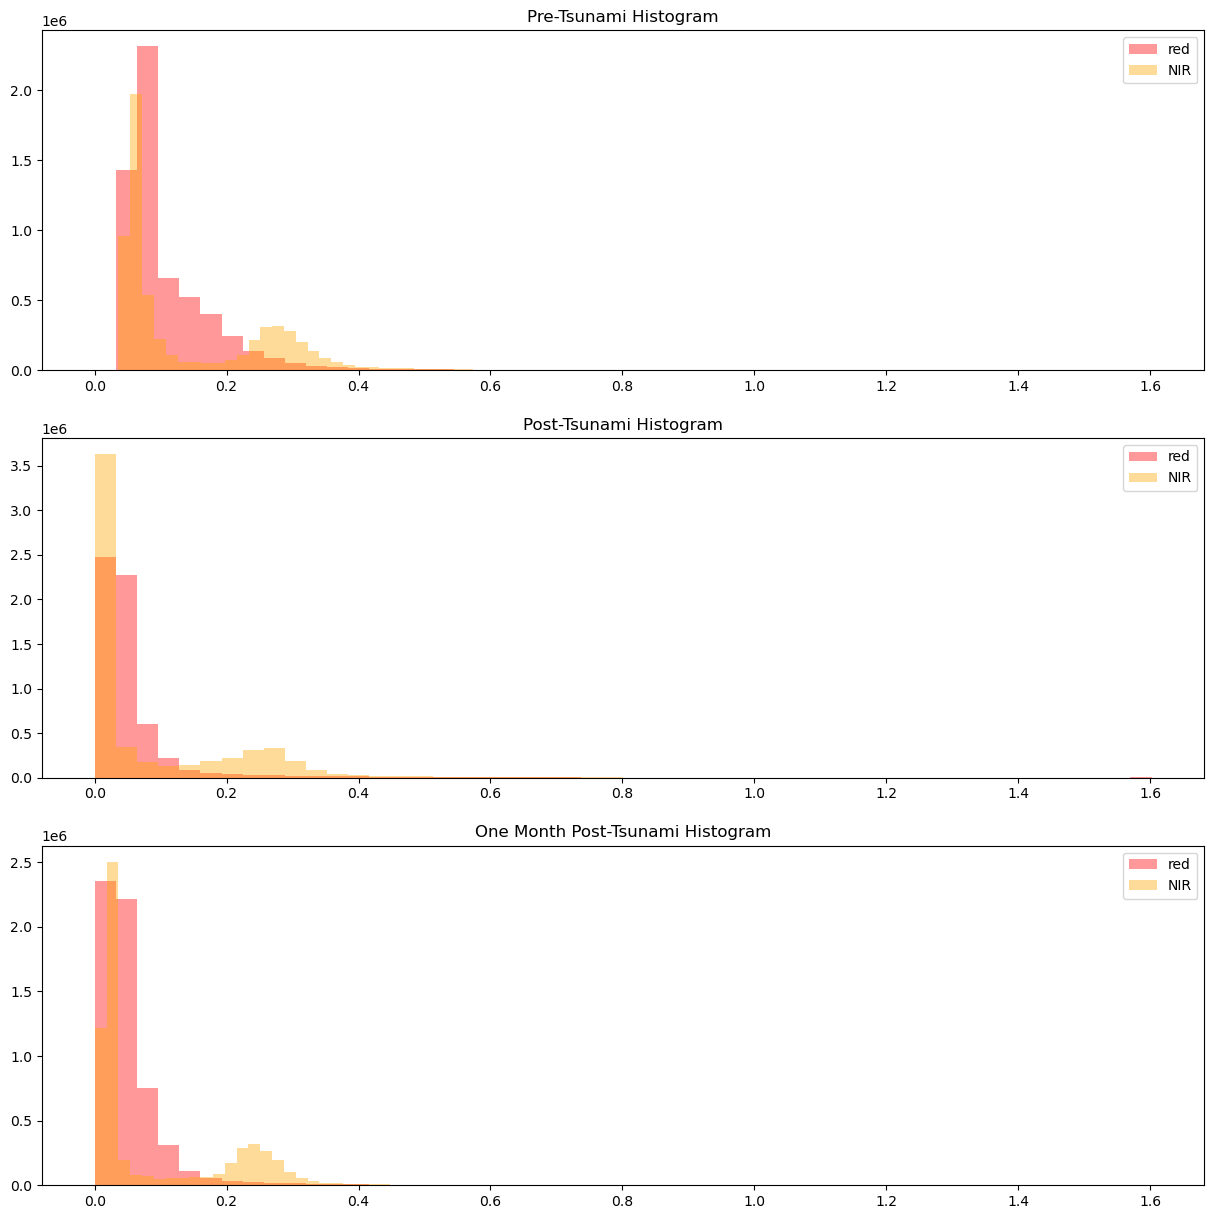

In [11]:
# create a histogram for each image showing break down of colour bands
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

pre_tsu_bands = pre_tsu_raster.read()[2:,:,:]  
post_tsu_bands = post_tsu_raster.read()[2:,:,:]  
one_month_post_tsu_bands = one_month_post_tsu_raster.read()[2:,:,:]

colors = ["red", "orange"]     
labels = ["red", "NIR"]

for i in range(pre_tsu_bands.shape[0]):
    axs[0].hist(pre_tsu_bands[i].ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colors[i],label=labels[i],range=(0, pre_tsu_bands[i].max()))
    axs[1].hist(post_tsu_bands[i].ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colors[i],label=labels[i],range=(0, post_tsu_bands[i].max()))
    axs[2].hist(one_month_post_tsu_bands[i].ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colors[i],label=labels[i],range=(0, one_month_post_tsu_bands[i].max()))

axs[0].set_title("Pre-Tsunami Histogram")
axs[0].legend()
axs[1].set_title("Post-Tsunami Histogram")
axs[1].legend()
axs[2].set_title("One Month Post-Tsunami Histogram")
axs[2].legend()

In [12]:
# generate ndvi 

pre_tsu_nir = pre_tsu_raster.read(4, out_dtype=float)
pre_tsu_red = pre_tsu_raster.read(3, out_dtype=float)
pre_tsu_ndvi = (pre_tsu_nir - pre_tsu_red) / (pre_tsu_nir + pre_tsu_red)

post_tsu_nir = post_tsu_raster.read(4, out_dtype=float)
post_tsu_red = post_tsu_raster.read(3, out_dtype=float)
post_tsu_ndvi = (post_tsu_nir - post_tsu_red) / (post_tsu_nir + post_tsu_red)

one_month_post_tsu_nir = one_month_post_tsu_raster.read(4, out_dtype=float)
one_month_post_tsu_red = one_month_post_tsu_raster.read(3, out_dtype=float)
one_month_post_tsu_ndvi = (one_month_post_tsu_nir - one_month_post_tsu_red) / (one_month_post_tsu_nir + one_month_post_tsu_red)

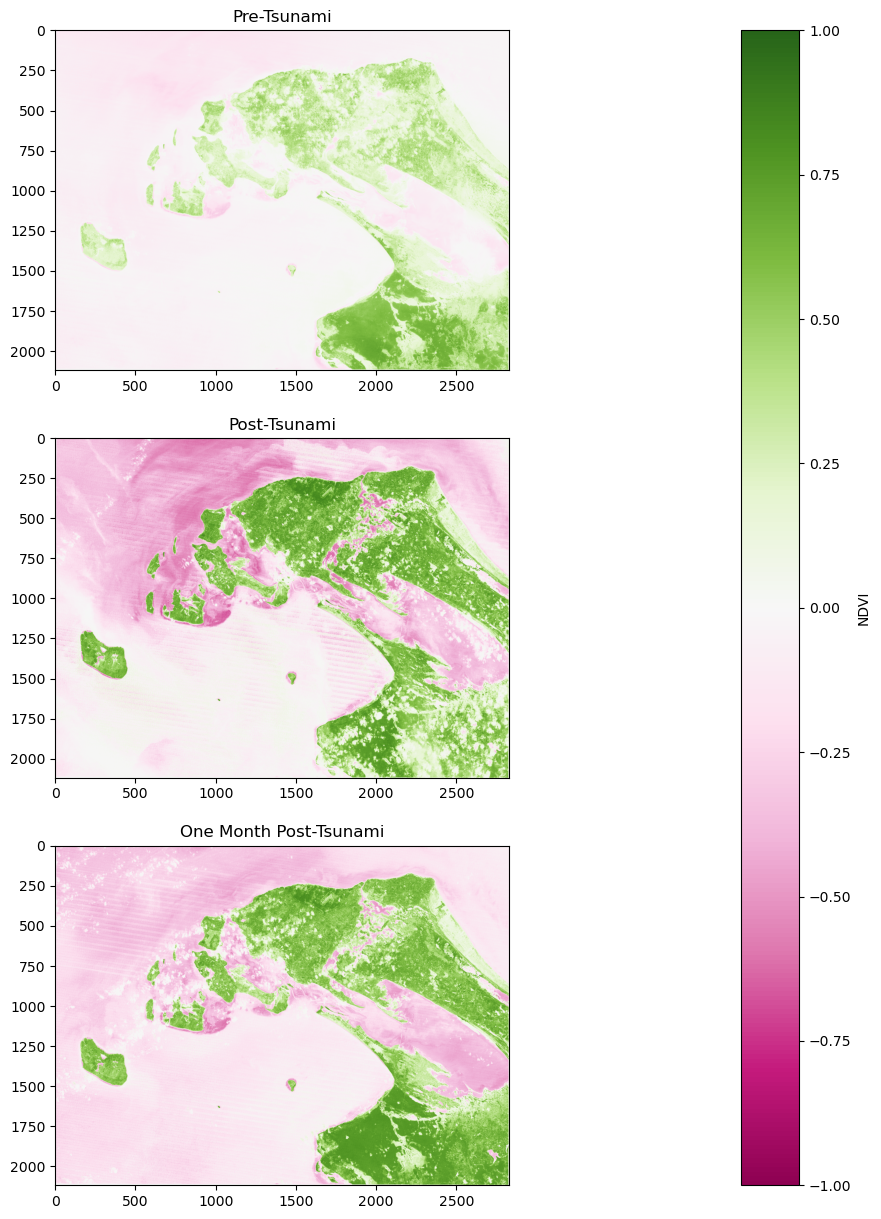

In [13]:
# subplot
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

cmap = 'PiYG'
vmin, vmax = -1, 1

# Plot each NDVI image
im1 = axs[0].imshow(pre_tsu_ndvi, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title("Pre-Tsunami")

im2 = axs[1].imshow(post_tsu_ndvi, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_title("Post-Tsunami")

im3 = axs[2].imshow(one_month_post_tsu_ndvi, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].set_title("One Month Post-Tsunami")

# Add a single colorbar at the bottom
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
                    ax=axs, orientation='vertical', fraction=0.05, pad=0.2)
cbar.set_label("NDVI")

plt.show()

In [14]:
# calculate area where ndvi > 0.5 for each image
pre_tsu_vegetation_area = np.sum(pre_tsu_ndvi > 0.5)
pre_tsu_pct_covered_by_vegetation = round(pre_tsu_vegetation_area / pre_tsu_ndvi.size * 100,3)
post_tsu_vegetation_area = np.sum(post_tsu_ndvi > 0.5)
post_tsu_pct_covered_by_vegetation = round(post_tsu_vegetation_area / post_tsu_ndvi.size * 100,3)
one_month_post_tsu_vegetation_area = np.sum(one_month_post_tsu_ndvi > 0.5)
one_month_post_tsu_pct_covered_by_vegetation = round(one_month_post_tsu_vegetation_area / one_month_post_tsu_ndvi.size * 100,3)
# tabulate results
vegetation_area_df = pd.DataFrame({
    "Time": ["Pre-Tsunami", "Post-Tsunami", "One Month Post-Tsunami"],
    "Vegetation Area (pixels)": [pre_tsu_vegetation_area, post_tsu_vegetation_area, one_month_post_tsu_vegetation_area],
    "Percentage Covered by Vegetation (%)": [pre_tsu_pct_covered_by_vegetation, post_tsu_pct_covered_by_vegetation, one_month_post_tsu_pct_covered_by_vegetation]
})
vegetation_area_df

Time  Vegetation Area (pixels)  \
0             Pre-Tsunami                    295892   
1            Post-Tsunami                   1019117   
2  One Month Post-Tsunami                   1070477   

   Percentage Covered by Vegetation (%)  
0                                 4.938  
1                                17.008  
2                                17.866

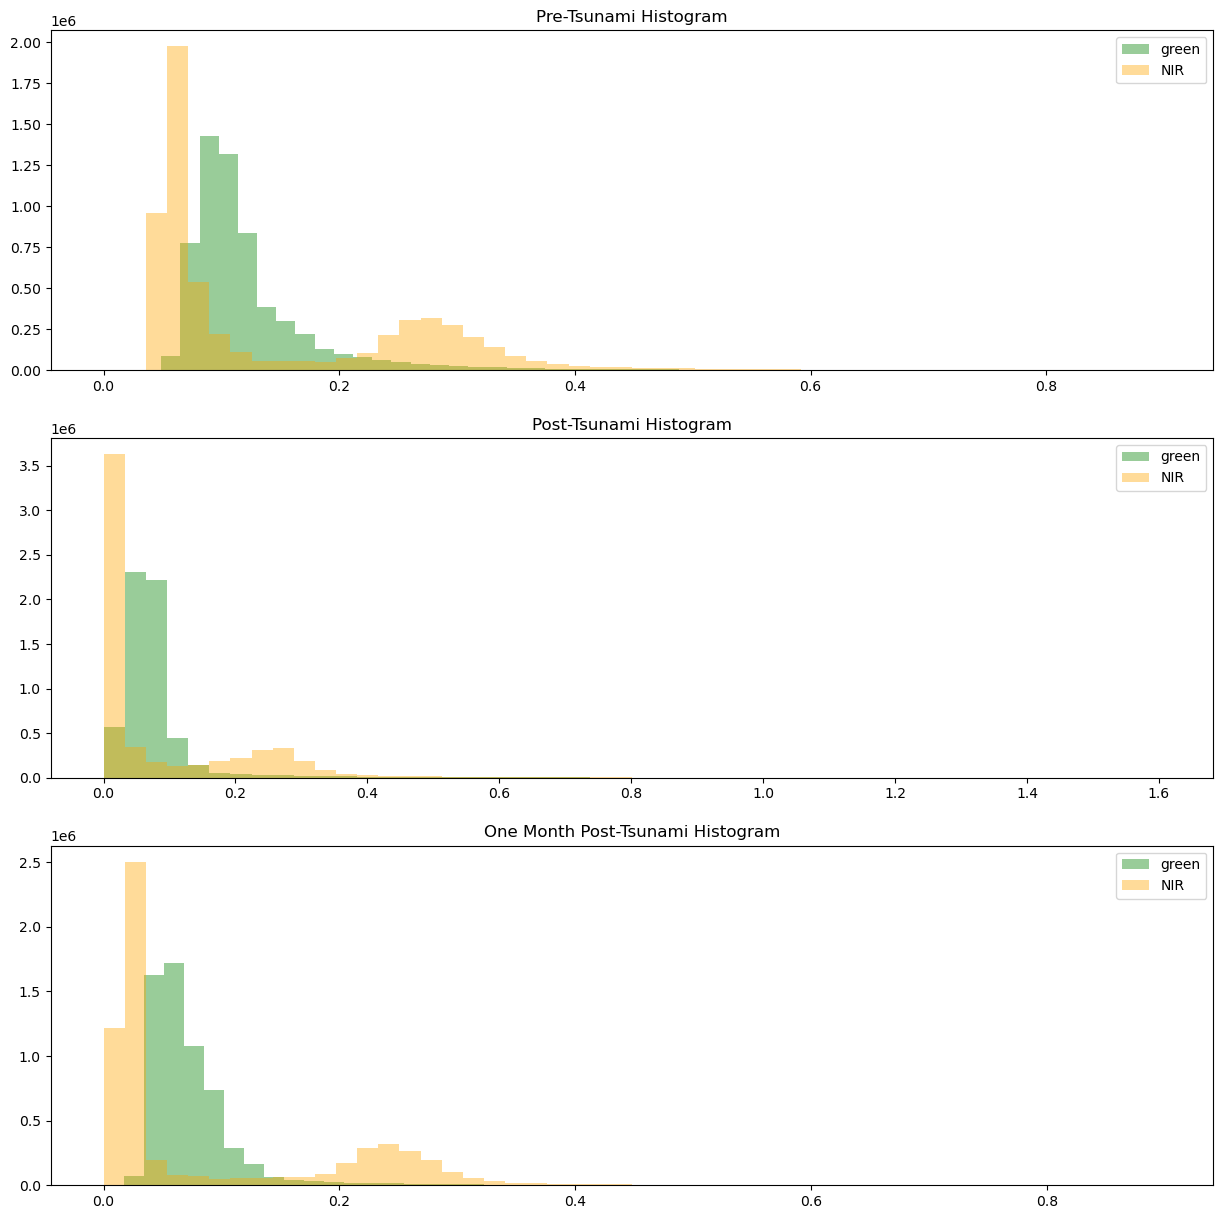

In [15]:
# create a histogram for each image showing break down of colour bands for ndwi
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

pre_tsu_bands = pre_tsu_raster.read()[[1,-1],:,:]  
post_tsu_bands = post_tsu_raster.read()[[1,-1],:,:]  
one_month_post_tsu_bands = one_month_post_tsu_raster.read()[[1,-1],:,:]

colors = ["green", "orange"]     
labels = ["green", "NIR"]

for i in range(pre_tsu_bands.shape[0]):
    axs[0].hist(pre_tsu_bands[i].ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colors[i],label=labels[i],range=(0, pre_tsu_bands[i].max()))
    axs[1].hist(post_tsu_bands[i].ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colors[i],label=labels[i],range=(0, post_tsu_bands[i].max()))
    axs[2].hist(one_month_post_tsu_bands[i].ravel(),bins=50,histtype="stepfilled",alpha=0.4,lw=0.0,color=colors[i],label=labels[i],range=(0, one_month_post_tsu_bands[i].max()))

axs[0].set_title("Pre-Tsunami Histogram")
axs[0].legend()
axs[1].set_title("Post-Tsunami Histogram")
axs[1].legend()
axs[2].set_title("One Month Post-Tsunami Histogram")
axs[2].legend()

In [16]:
# generate ndwi 

pre_tsu_green = pre_tsu_raster.read(2, out_dtype=float)
pre_tsu_ndwi = (pre_tsu_green - pre_tsu_nir) / (pre_tsu_green + pre_tsu_nir)

post_tsu_green = post_tsu_raster.read(2, out_dtype=float)
post_tsu_ndwi = (post_tsu_green - post_tsu_nir) / (post_tsu_green + post_tsu_nir)

one_month_post_tsu_green = one_month_post_tsu_raster.read(2, out_dtype=float)
one_month_post_tsu_ndwi = (one_month_post_tsu_green - one_month_post_tsu_nir) / (one_month_post_tsu_green + one_month_post_tsu_nir)


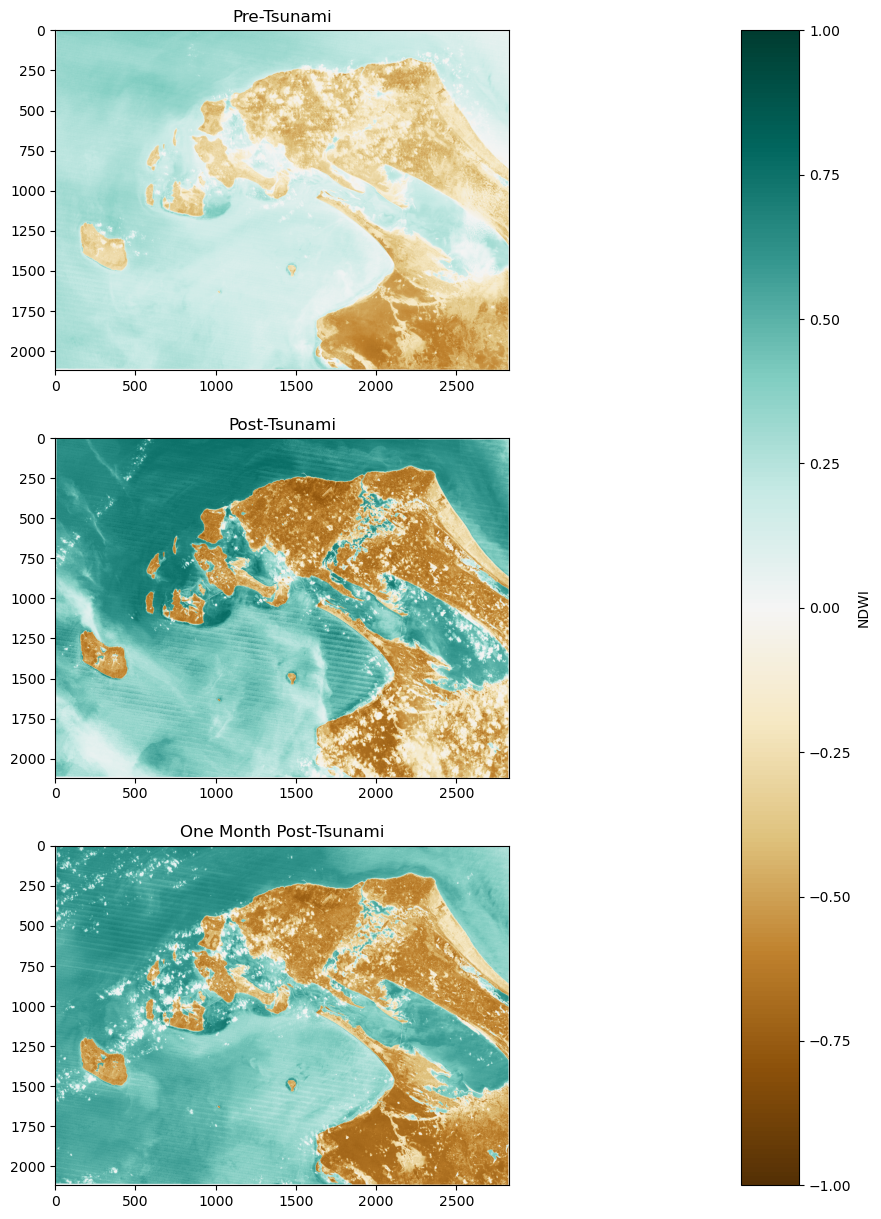

In [17]:
# subplot
fig, axs = plt.subplots(3, 1, figsize=(15, 15))

cmap = 'BrBG'
vmin, vmax = -1, 1

# Plot each NDVI image
im1 = axs[0].imshow(pre_tsu_ndwi, cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].set_title("Pre-Tsunami")

im2 = axs[1].imshow(post_tsu_ndwi, cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].set_title("Post-Tsunami")

im3 = axs[2].imshow(one_month_post_tsu_ndwi, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].set_title("One Month Post-Tsunami")

# Add a single colorbar at the bottom
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax)),
                    ax=axs, orientation='vertical', fraction=0.05, pad=0.2)
cbar.set_label("NDWI")

plt.show()

In [18]:
# calculate area where ndwi > 0.5 for each image
pre_tsu_water_area = np.sum(pre_tsu_ndwi > 0)
pre_tsu_pct_covered_by_water = round(pre_tsu_water_area / pre_tsu_ndwi.size * 100,3)
post_tsu_water_area = np.sum(post_tsu_ndwi > 0)
post_tsu_pct_covered_by_water = round(post_tsu_water_area / post_tsu_ndwi.size * 100,3)
one_month_post_tsu_water_area = np.sum(one_month_post_tsu_ndwi > 0)
one_month_post_tsu_pct_covered_by_water = round(one_month_post_tsu_water_area / one_month_post_tsu_ndwi.size * 100,3)
# tabulate results
water_area_df = pd.DataFrame({
    "Time": ["Pre-Tsunami", "Post-Tsunami", "One Month Post-Tsunami"],
    "Water Area (pixels)": [pre_tsu_water_area, post_tsu_water_area, one_month_post_tsu_water_area],
    "Percentage Covered by Water (%)": [pre_tsu_pct_covered_by_water, post_tsu_pct_covered_by_water, one_month_post_tsu_pct_covered_by_water]
})
water_area_df

Time  Water Area (pixels)  \
0             Pre-Tsunami              3926719   
1            Post-Tsunami              4091919   
2  One Month Post-Tsunami              4079007   

   Percentage Covered by Water (%)  
0                           65.535  
1                           68.292  
2                           68.076

In [21]:
# preparing data for classification

pre_tsu_raster = preprocess_data(folder_path = "data/pre_tsu", area_of_interest = cropped_data_area, create_new = True, new_file_name = "pre_tsunami_all_bands_processed.tif", bands = [1, 2, 3, 4, 5, 6, 7])
post_tsu_raster = preprocess_data(folder_path = "data/eight_days_post_tsu", area_of_interest = cropped_data_area, create_new = True, new_file_name = "directly_post_tsunami_all_bands_processed.tif", bands = [1, 2, 3, 4, 5, 6, 7])
one_month_post_tsu_raster = preprocess_data(folder_path = "data/one_month_post_tsu", area_of_interest = cropped_data_area, create_new = True, new_file_name = "one_month_post_tsunami_all_bands_processed.tif", bands = [1, 2, 3, 4, 5, 6, 7])

Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 5 done
Band 6 done
Band 7 done
Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 5 done
Band 6 done
Band 7 done
Band 1 done
Band 2 done
Band 3 done
Band 4 done
Band 5 done
Band 6 done
Band 7 done


In [22]:

pre_tsu_raster = preprocess_data(folder_path = "data/pre_tsu", area_of_interest = cropped_data_area, create_new = False, new_file_name = "pre_tsunami_all_bands_processed.tif")
post_tsu_raster = preprocess_data(folder_path = "data/eight_days_post_tsu", area_of_interest = cropped_data_area, create_new = False, new_file_name = "directly_post_tsunami_all_bands_processed.tif")
one_month_post_tsu_raster = preprocess_data(folder_path = "data/one_month_post_tsu", area_of_interest = cropped_data_area, create_new = False, new_file_name = "one_month_post_tsunami_all_bands_processed.tif")

In [23]:
# fig, axes = plt.subplots(2, 4, figsize=(15, 10))  
# axes = axes.flatten()  

# for i in range(7):
#     band = pre_tsu_raster.read()[i] 
#     ax = axes[i]
#     ax.imshow(band, cmap='gist_earth')
#     ax.set_title(f'Band {i + 1}')
#     ax.axis('off')  

# plt.tight_layout()
# plt.show()

In [24]:
pre_tsu_x = np.moveaxis(pre_tsu_raster.read(), 0, -1)
print(pre_tsu_x.shape)

post_tsu_x = np.moveaxis(post_tsu_raster.read(), 0, -1)
print(post_tsu_x.shape)

one_month_post_tsu_x = np.moveaxis(one_month_post_tsu_raster.read(), 0, -1)
print(one_month_post_tsu_x.shape)

(2118, 2829, 7)
(2118, 2829, 7)
(2118, 2829, 7)


In [25]:
pre_tsu_x_data = pre_tsu_x.reshape(-1, 7)
pre_tsu_scaler = StandardScaler().fit(pre_tsu_x_data)
pre_tsu_x_scaled = pre_tsu_scaler.transform(pre_tsu_x_data)

post_tsu_x_data = post_tsu_x.reshape(-1, 7)
post_tsu_scaler = StandardScaler().fit(post_tsu_x_data)
post_tsu_x_scaled = post_tsu_scaler.transform(post_tsu_x_data)

one_month_post_tsu_x_data = one_month_post_tsu_x.reshape(-1, 7)
one_month_post_tsu_scaler = StandardScaler().fit(one_month_post_tsu_x_data)
one_month_post_tsu_x_scaled = one_month_post_tsu_scaler.transform(one_month_post_tsu_x_data)

In [26]:
k = 6 

LOKY_MAX_CPU_COUNT = 2
pre_tsu_kmeans_predictions = KMeans(n_clusters=k, random_state=2).fit(pre_tsu_x_scaled)
pre_tsu_kmeans_predictions_2d = pre_tsu_kmeans_predictions.labels_.reshape(2118, 2829)

post_tsu_kmeans_predictions = KMeans(n_clusters=k, random_state=2).fit(post_tsu_x_scaled)
post_tsu_kmeans_predictions_2d = post_tsu_kmeans_predictions.labels_.reshape(2118, 2829)

one_month_post_tsu_kmeans_predictions = KMeans(n_clusters=k, random_state=2).fit(one_month_post_tsu_x_scaled)
one_month_post_tsu_kmeans_predictions_2d = one_month_post_tsu_kmeans_predictions.labels_.reshape(2118, 2829)

C:\Users\foxy_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\foxy_\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\foxy_\anaconda3\envs\qcr_env\Lib\subproce

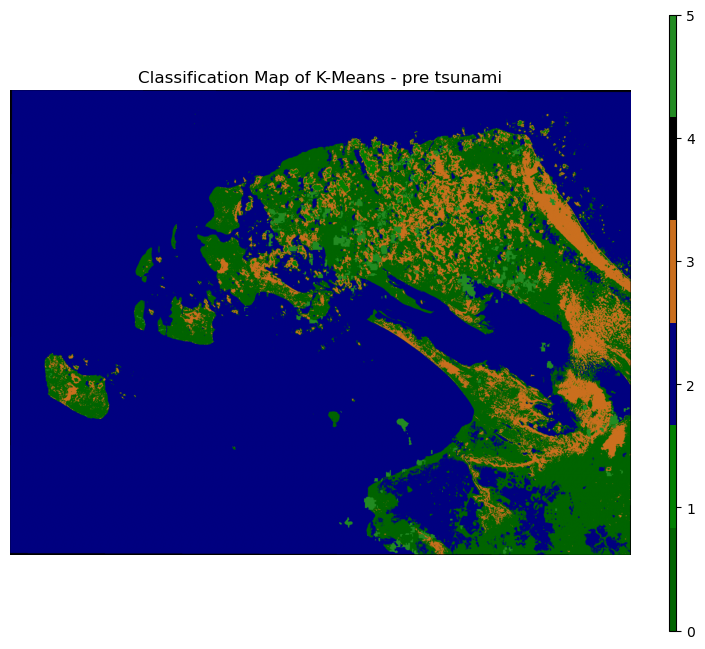

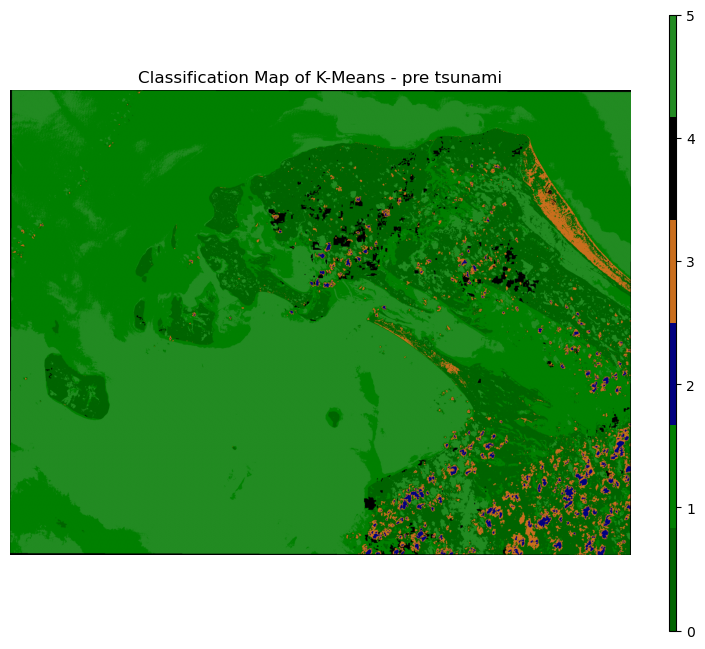

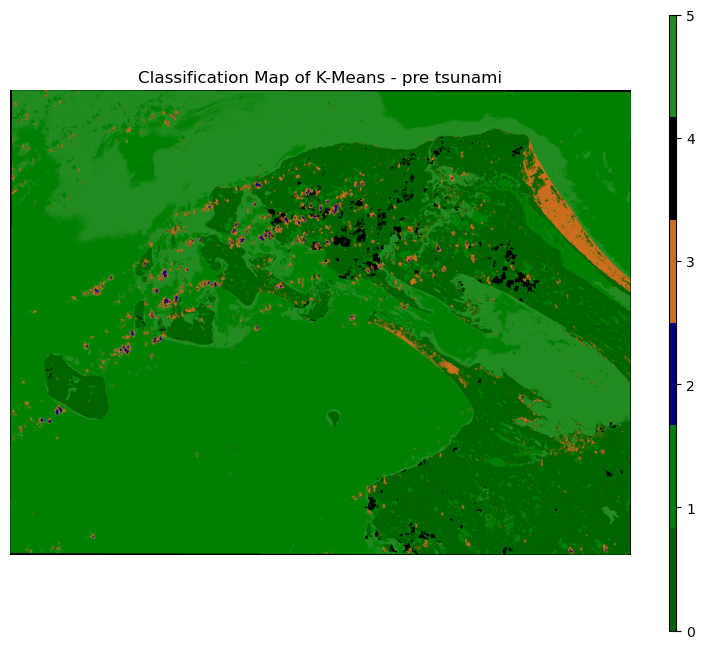

In [27]:
cmap = ListedColormap(['darkgreen', 'green', 'navy', '#CA6F1E', 'black', 'forestgreen'])

plt.figure(figsize=(10, 8))
plt.imshow(pre_tsu_kmeans_predictions_2d, cmap=cmap)
plt.colorbar(aspect=80) 
plt.title('Classification Map of K-Means - pre tsunami')
plt.axis('off')  
plt.show()


plt.figure(figsize=(10, 8))
plt.imshow(post_tsu_kmeans_predictions_2d, cmap=cmap)
plt.colorbar(aspect=80) 
plt.title('Classification Map of K-Means - pre tsunami')
plt.axis('off')  
plt.show()


plt.figure(figsize=(10, 8))
plt.imshow(one_month_post_tsu_kmeans_predictions_2d, cmap=cmap)
plt.colorbar(aspect=80) 
plt.title('Classification Map of K-Means - pre tsunami')
plt.axis('off')  
plt.show()